## CuffDiff Summary
### Author: Xiang Li



In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
# For any input of /gene_exp.diff, return its All genes with
### gene_id, cond1, cond2, log2(fold_change), p_value, plus a number of order.
def generate_All_Genes(Input_Path, number):
#### READ FILE
    df = pd.read_csv(Input_Path+'/gene_exp.diff', sep='\t', header=0, usecols={'test_id',\
    'status','sample_1','sample_2','value_1','value_2','log2(fold_change)','p_value','q_value'})
#### Rename columns
    df=df.rename(columns={'test_id':'gene_id', 'value_1': df['sample_1'].unique()[0], 'value_2': df['sample_2'].unique()[0]})
#### Output   
    return df.loc[:,['gene_id',df['sample_1'].unique()[0],df['sample_2'].unique()[0],'log2(fold_change)',
                     'p_value','q_value', 'End_'+str(number), '||']].fillna('')
####################################################################################


### For any input of /gene_exp.diff, return its up_DEGs genes with
### gene_id, cond1, cond2, log2(fold_change), p_value, plus a number of order.
### Parameters for DEGs:
FC_UP=2.0
q_value_less=0.05
FPKM_threshold=1.0
####################################################################################

def generate_Upregulated_Genes(Input_Path):
#### READ FILE
    df = pd.read_csv(Input_Path+'/gene_exp.diff', sep='\t', header=0, usecols={'test_id',\
    'status','sample_1','sample_2', 'value_1','value_2','log2(fold_change)','p_value','q_value'})
#### Filter
    df=df[(df['status']=='OK') & (df['q_value']<=q_value_less) & (df['value_2']>=FPKM_threshold) & ( (df['log2(fold_change)'] >= np.log2(FC_UP)))]
#### Rearrange Columns
    df=df.rename(columns={'test_id':'gene_id','value_1': df['sample_1'].unique()[0], 'value_2': df['sample_2'].unique()[0]})
#### Output
    return df.loc[:,['gene_id', df['sample_1'].unique()[0],df['sample_2'].unique()[0],'log2(fold_change)','p_value','q_value']]
####################################################################################

def generate_Downregulated_Genes(Input_Path):
#### READ FILE FROM CuffDiff Results
    df = pd.read_csv(Input_Path+'/gene_exp.diff', sep='\t', header=0, usecols={'test_id',\
    'status','sample_1','sample_2', 'value_1','value_2','log2(fold_change)','p_value','q_value'})
#### Filter
    df=df[(df['status']=='OK') & (df['q_value']<=q_value_less) & (df['value_1']>=FPKM_threshold) & (df['log2(fold_change)']<= -np.log2(FC_UP))]   
#### Rearrange Columns
    df=df.rename(columns={'test_id':'gene_id','value_1': df['sample_1'].unique()[0], 'value_2': df['sample_2'].unique()[0]})
#### Output
    return df.loc[:,['gene_id', df['sample_1'].unique()[0],df['sample_2'].unique()[0],'log2(fold_change)','p_value','q_value']]


#### Functions to read /genes.read_group_tracking and output FPKM
def generate_genes_FPKM_df(Input_Path):
    df = pd.read_csv(INPUT_PATH+'/genes.read_group_tracking', sep='\t', header=0)
    FPKM_df = None
    for cond in df['condition'].unique():
        for replica in df[df['condition'] == cond]['replicate'].unique():
            #print (cond, replica)
            temp_df = (df[ (df['condition'] == cond) & (df['replicate'] == replica)].loc[:,['tracking_id', 'FPKM']])
            cond_name= cond+'_'+str(replica)
            temp_df.rename(columns={'tracking_id': 'gene_id', 'FPKM': cond_name }, inplace=True)
            if FPKM_df is None:
                FPKM_df
                FPKM_df = temp_df  
            else:
                FPKM_df = FPKM_df.merge(temp_df, on='gene_id', how='outer', suffixes=('','_'))
    return FPKM_df

def Add_common_header(df,common_header):
    name_list=[common_header]*len(df.columns)
    tuples = list(zip(name_list,df.columns))
    df.columns = pd.MultiIndex.from_tuples(tuples)
    return df


def DIR_CHECK_CREATE(Input_Path):
    if (not os.path.isdir(Input_Path)):
        print ("New Dir Made is" + Input_Path)
        os.mkdir(Input_Path)
    else: 
        print ('Dir Exists')

## Generate Excel file contains all genes, and DEGs. 

In [16]:
PATH_FOLDER=os.getcwd()+ '/CuffDiff_Results/'
OUT_FOLDER=os.getcwd()+'/genelist/'

DIR_CHECK_CREATE(PATH_FOLDER)
DIR_CHECK_CREATE(OUT_FOLDER)


INPUT_LIST=os.listdir(PATH_FOLDER)
writer = pd.ExcelWriter(OUT_FOLDER+'CD8-HP_CuffDiff_Summary201806.xlsx', engine='xlsxwriter')

i=0
for input_name in INPUT_LIST[:]:
    INPUT_PATH = PATH_FOLDER+input_name
    if (i==0):
        df_all=generate_genes_FPKM_df(INPUT_PATH)
        df_all[input_name]=''
        df_all = df_all.merge(generate_All_Genes(INPUT_PATH,i+1), on='gene_id', how='inner', suffixes=('','_')) 
        i+=1
        continue
    df_all = df_all.merge(generate_genes_FPKM_df(INPUT_PATH), on='gene_id', how='inner', suffixes=('','_'))
    df_all[input_name]=''
    df_all = df_all.merge(generate_All_Genes(INPUT_PATH,i+1), on='gene_id', how='inner', suffixes=('','_')) 
    
    i+=1
df_all.to_excel(writer, sheet_name='All_Genes', index=None)



###### Generating a DEGs list in the last.
DEGs_List=pd.DataFrame([],columns=['gene_id'])


for input_name in INPUT_LIST:
    INPUT_PATH = PATH_FOLDER+input_name
    print ('Library:' + input_name)
    df_up = generate_genes_FPKM_df(INPUT_PATH)
    df_up[input_name]=''
    df_up = df_up.merge(generate_Upregulated_Genes(INPUT_PATH), on='gene_id', how='inner', suffixes=('','_'))
    df_up.to_excel( writer, sheet_name='up_'+input_name, index=None)
    
    DEGs_List=pd.concat([DEGs_List,df_up[['gene_id']]])
    print ('# of Up:' )
    print(df_up.shape)
    
    df_down = generate_genes_FPKM_df(INPUT_PATH)
    df_down[input_name]=''
    df_down = df_down.merge(generate_Downregulated_Genes(INPUT_PATH), on='gene_id', how='inner', suffixes=('','_')) 
    df_down.to_excel( writer, sheet_name='down_'+input_name,index=None)
    DEGs_List=pd.concat([DEGs_List,df_down[['gene_id']]])
    print ('# of Down')
    print(df_down.shape)
    print ('')

print ("Total Number of DEGs is:" + str(len(DEGs_List['gene_id'].unique())))

DEGs_List = pd.DataFrame( list(DEGs_List['gene_id'].unique()), columns=['gene_id'])
DEGs_List.to_excel( writer, sheet_name='Union_DGEs_List',index=None)

writer.save()

Dir Exists
Dir Exists
Library:DKO_0h_vs_WT_0h
# of Up:
(313, 13)
# of Down
(259, 13)

Library:DKO_72h_vs_WT_0h
# of Up:
(792, 13)
# of Down
(536, 13)

Library:DKO_72h_vs_DKO_0h
# of Up:
(618, 13)
# of Down
(428, 13)

Library:DKO_72h_vs_WT_72h
# of Up:
(179, 13)
# of Down
(424, 13)

Library:WT_72h_vs_WT_0h
# of Up:
(954, 13)
# of Down
(493, 13)

Total Number of DEGs is:2234


In [5]:
print len (df_all[(df_all.iloc[:,10]>=2) ])
print len(df_all[df_all.iloc[:,10]>=2])
print len(df_all[np.isinf(df_all.iloc[:,10])])
np.isinf(df_all.iloc[:,10]) & (df_all.iloc[:,10]>=2)
(df_all.iloc[:,10]>=2)
df_all.iloc[23949,10] >= 2

#df_all

1441
1441
1683


True

In [17]:
#### Generate DEGs Seperately

#os.makedirs(os.getcwd()+'/genelist/')
PATH_FOLDER=os.getcwd()+ '/CuffDiff_Results/'
INPUT_LIST=os.listdir(PATH_FOLDER)
for input_name in INPUT_LIST:
    INPUT_PATH = PATH_FOLDER+input_name
    print ('Library:' + input_name)
    df_up = generate_Upregulated_Genes(INPUT_PATH)
    df_up.to_csv( os.getcwd()+'/genelist/up_'+input_name +'.bed' ,sep='\t')
    print ('# of Up:' )
    print(df_up.shape)
    
    df_down = generate_Downregulated_Genes(INPUT_PATH)  
    df_down.to_csv( os.getcwd()+'/genelist/down_'+input_name + '.bed' ,sep='\t')
    print ('# of Down')
    print(df_down.shape)
    print ('')


Library:DKO_0h_vs_WT_0h
# of Up:
(313, 6)
# of Down
(259, 6)

Library:DKO_72h_vs_WT_0h
# of Up:
(792, 6)
# of Down
(536, 6)

Library:DKO_72h_vs_DKO_0h
# of Up:
(618, 6)
# of Down
(428, 6)

Library:DKO_72h_vs_WT_72h
# of Up:
(179, 6)
# of Down
(424, 6)

Library:WT_72h_vs_WT_0h
# of Up:
(954, 6)
# of Down
(493, 6)



### Test output Results

In [25]:
df_all=generate_genes_FPKM_df(INPUT_PATH)
df_down = generate_genes_FPKM_df(INPUT_PATH)
df_down[df_down['gene_id']=='Rnaset2a,Rnaset2b']

,gene_id,WT_0h_0,WT_0h_1,WT_0h_2,WT_72h_0,WT_72h_1,WT_72h_2


In [3]:
All_gene_list= pd.read_excel(os.getcwd()+'/genelist/CD8-HP_CuffDiff_Summary201806.xlsx', 
                sheet_name='All_Genes', index_col=None, usecols=[0])


#### ALL DEGs Generating

In [9]:
#DEGs_List
[INPUT_LIST[0],INPUT_LIST[2]]


Dir Exists


['DKO_0h_vs_WT_0h', 'DKO_72h_vs_WT_72h']

In [4]:
####Generating  FPKM of all DEGs replicates
DIR_CHECK_CREATE(os.getcwd()+'/genelist/')
PATH_FOLDER=os.getcwd()+ '/CuffDiff_Results/'
INPUT_LIST=os.listdir(PATH_FOLDER)

DEGs_INPUT_LIST=[INPUT_LIST[0],INPUT_LIST[3]]
DEGs_INPUT_LIST=DEGs_INPUT_LIST

#DEGs_List
#df_ALL_DEGs = DEGs_List

#### This line means I use All gene list instead of DEGs_List
df_ALL_DEGs = All_gene_list[['gene_id']]
#### This line means I use All gene list instead of DEGs_List

for input_name in DEGs_INPUT_LIST:
    INPUT_PATH = PATH_FOLDER+input_name
    print ('Library:' + input_name)
    df_ALL_DEGs = df_ALL_DEGs.merge(generate_genes_FPKM_df(INPUT_PATH), on='gene_id',how='inner')



print ('# of DEGs:' )
print(df_ALL_DEGs.shape)
df_ALL_DEGs=df_ALL_DEGs.set_index('gene_id')


Dir Exists
Library:DKO_0h_vs_WT_0h
Library:DKO_72h_vs_WT_72h
# of DEGs:
(23951, 13)


## From above we can continue using:
# "df_ALL_DEGs" for plot

# Plot Part

In [5]:
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white") 

# display plots in this notebook
%matplotlib inline

In [4]:
def Generate_Venn_Diagram(Raw_Path, Out_Path, Merge_Column):
    from matplotlib_venn import venn2
    
    DIR_CHECK_CREATE(Raw_Path)
    DIR_CHECK_CREATE(Out_Path)
    Merge_Column='gene_id'
    
    INPUT_LIST=os.listdir(RAW_PATH)
    FILE_TYPE=INPUT_LIST[0][-4:]
    print('Input File: ' )
    print(INPUT_LIST)
    
    if len(INPUT_LIST) == 2:
        print ('Input Two, Continue.')
        PATH_A = RAW_PATH + '/' +INPUT_LIST[0]
        PATH_B = RAW_PATH + '/' +INPUT_LIST[1]

        df_A = pd.read_csv(PATH_A,sep='\t')
        df_B = pd.read_csv(PATH_B,sep='\t')

        ### Union A and B, use indicator to differentiate them.
        union_A_B=df_A.loc[:, [Merge_Column]].merge(df_B.loc[:,[Merge_Column]], how='outer', indicator=True)

        intersection_A_B=union_A_B[union_A_B['_merge']=='both']
        only_A=union_A_B[union_A_B['_merge']=='left_only']
        only_B=union_A_B[union_A_B['_merge']=='right_only']

        #Output
        intersection_A_B.to_csv(OUT_PATH+'/Intersection_'+INPUT_LIST[0][:-4]+'_'+INPUT_LIST[1][:-4]+FILE_TYPE,index=None, columns=[Merge_Column])
        only_A.to_csv(OUT_PATH+'/Only_'+INPUT_LIST[0][:-4]+FILE_TYPE,index=None, columns=[Merge_Column])
        only_B.to_csv(OUT_PATH+'/Only_'+INPUT_LIST[1][:-4]+FILE_TYPE,index=None, columns=[Merge_Column])
        union_A_B.to_csv(OUT_PATH+'/Union_'+INPUT_LIST[0][:-4]+'_'+INPUT_LIST[1][:-4]+FILE_TYPE,index=None, columns=[Merge_Column])
    else:
        print('Error!')
        print('Input '+str(len(INPUT_LIST))+ ' Files')


    out = venn2(subsets=(len(only_A[Merge_Column]), len(only_B[Merge_Column]), len(intersection_A_B[Merge_Column])),
          set_labels=(INPUT_LIST[0][:-4], INPUT_LIST[1][:-4] ) )
    for text in out.subset_labels:
        text.set_fontsize(18)
    plt.show()
    
def Generate_Venn3_Diagram(Raw_Path, Out_Path, Merge_Column):
    from matplotlib_venn import venn3, venn3_circles
    
    DIR_CHECK_CREATE(Raw_Path)
    DIR_CHECK_CREATE(Out_Path)
    Merge_Column='gene_id'
    
    INPUT_LIST=os.listdir(RAW_PATH)
    FILE_TYPE=INPUT_LIST[0][-4:]
    print('Input File: ' )
    print(INPUT_LIST)
    
    if len(INPUT_LIST) == 3:
        print ('Input Three, Continue.')
        PATH_A = RAW_PATH + '/' +INPUT_LIST[0]
        PATH_B = RAW_PATH + '/' +INPUT_LIST[1]
        PATH_C = RAW_PATH + '/' +INPUT_LIST[2]

        ConA=INPUT_LIST[0][:-4]
        ConB=INPUT_LIST[1][:-4]
        ConC=INPUT_LIST[2][:-4]

        df_A = pd.read_csv(PATH_A,sep='\t')
        df_B = pd.read_csv(PATH_B,sep='\t')
        df_C = pd.read_csv(PATH_C,sep='\t')

        Merge_Column='gene_id'

        union_A_B_C = df_C.loc[:, [Merge_Column]].merge( df_A.loc[:, [Merge_Column]].merge(df_B.loc[:,[Merge_Column]], how='outer'), how='outer')

        intersection_metrix=np.zeros( (len(union_A_B_C),3), dtype=int)


        for j in range(len(union_A_B_C)):
            if (union_A_B_C.loc[j,'gene_id'] in df_A.loc[:,'gene_id']):
                intersection_metrix[j,0] == 1
            if (union_A_B_C.loc[j,'gene_id'] in df_B.loc[:,'gene_id']):
                intersection_metrix[j,1] == 1
            if (union_A_B_C.loc[j,'gene_id'] in df_C.loc[:,'gene_id']):
                intersection_metrix[j,2] == 1

        intersection_metrix = pd.DataFrame(union_A_B_C['gene_id'].isin(df_A['gene_id']))
        intersection_metrix = pd.concat([intersection_metrix.rename(columns={'gene_id':ConA}),union_A_B_C['gene_id'].isin(df_B['gene_id'])], axis=1, join='inner')
        intersection_metrix = pd.concat([intersection_metrix.rename(columns={'gene_id':ConB}),union_A_B_C['gene_id'].isin(df_C['gene_id'])], axis=1, join='inner')
        intersection_metrix = intersection_metrix.rename(columns={'gene_id':ConC})

        intersection_metrix = intersection_metrix*1


        intersection_metrix ['ABC'] = intersection_metrix.iloc[:,0]+intersection_metrix.iloc[:,1]+intersection_metrix.iloc[:,2]
        intersection_metrix ['AB'] = intersection_metrix.iloc[:,0]+intersection_metrix.iloc[:,1]
        intersection_metrix ['AC'] = intersection_metrix.iloc[:,0]+intersection_metrix.iloc[:,2]
        intersection_metrix ['BC'] = intersection_metrix.iloc[:,1]+intersection_metrix.iloc[:,2]
        #intersection_metrix
        ABC = len(intersection_metrix[intersection_metrix['ABC']==3])
        AB = len(intersection_metrix[intersection_metrix['AB']==2])   -ABC
        BC = len(intersection_metrix[(intersection_metrix['BC']==2)]) -ABC
        AC = len(intersection_metrix[(intersection_metrix['AC']==2)]) -ABC

        A_solo = len(df_A) - ABC - AC - AB 
        B_solo = len(df_B) - ABC - BC - AB 
        C_solo = len(df_C) - ABC - AC - BC
    else:
        print('Error!')
        print('Input '+str(len(INPUT_LIST))+ ' Files')
        
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8,8))
    out = venn3(subsets = (A_solo, B_solo, AB, C_solo, AC, BC,ABC), \
    set_labels = (ConA, ConB, ConC))
    for text in out.subset_labels:
        text.set_fontsize(18)

    

In [99]:
#Folder_Name='Up'
import glob
import fnmatch
RAW_PATH=os.getcwd() + '/genelist/Venn/'
OUT_PATH=os.getcwd() + '/genelist/Venn_Results/'
DIR_CHECK_CREATE(OUT_PATH)
#INPUT_LIST=os.listdir(RAW_PATH)
FILE_TYPE='bed'
Merge_Column='gene_id'
#INPUT_LIST[0][-4:]
print('Input File: ' )
#print(INPUT_LIST)
#OUT_PATH=os.getcwd() + '/genelist/Venn/Results_' + Folder_Name

union_all   = pd.DataFrame(columns={Merge_Column})
column_name_list = []
for path in glob.glob(RAW_PATH+'*.'+FILE_TYPE):
    print path
    df_tem = pd.read_csv(path,sep='\t', usecols=[Merge_Column])
    col_name_tem = path.replace(RAW_PATH,'')[:-4]
    df_tem[col_name_tem]=1
    column_name_list.append(col_name_tem)
    union_all = union_all.merge(df_tem, how='outer', on=Merge_Column)
union_all.fillna(0, inplace=True)

for i in range(len(column_name_list)):
    print column_name_list[i]
    
#union_all.to_csv(OUT_PATH+'Up_Up_Up_Down_union_all.bed', sep='\t', index=None)



Dir Exists
Input File: 
/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/RNA_seq/CuffDiff_Jun2018/genelist/Venn/down_DKO_72h_vs_WT_0h.bed
/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/RNA_seq/CuffDiff_Jun2018/genelist/Venn/up_DKO_0h_vs_WT_0h.bed
/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/RNA_seq/CuffDiff_Jun2018/genelist/Venn/down_WT_72h_vs_WT_0h.bed
/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/RNA_seq/CuffDiff_Jun2018/genelist/Venn/down_DKO_0h_vs_WT_0h.bed
down_DKO_72h_vs_WT_0h
up_DKO_0h_vs_WT_0h
down_WT_72h_vs_WT_0h
down_DKO_0h_vs_WT_0h


Dir Exists
Dir Exists
Input File: 
['down_DKO_72h_vs_WT_0h.bed', 'down_WT_72h_vs_WT_0h.bed', 'down_DKO_0h_vs_WT_0h.bed']
Input Three, Continue.


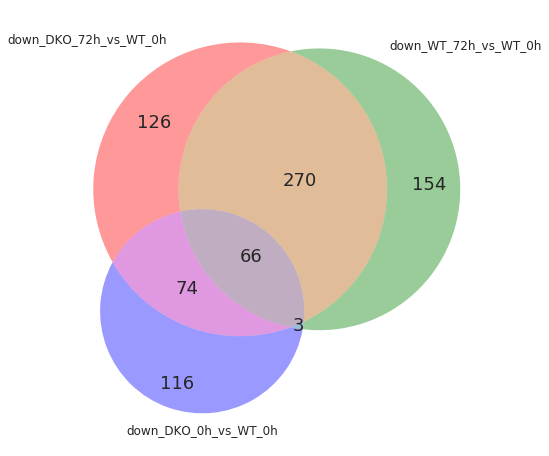

In [325]:
Folder_Name='Down'
RAW_PATH=os.getcwd() + '/genelist/Venn/' + Folder_Name
OUT_PATH=os.getcwd() + '/genelist/Venn/Results_' + Folder_Name

Generate_Venn3_Diagram(RAW_PATH, OUT_PATH, 'gene_id')

In [277]:
Folder_Name='Up'
RAW_PATH=os.getcwd() + '/genelist/Venn/' + Folder_Name
OUT_PATH=os.getcwd() + '/genelist/Venn/Results_' + Folder_Name

INPUT_LIST=os.listdir(RAW_PATH)
FILE_TYPE=INPUT_LIST[0][-4:]

PATH_A = RAW_PATH + '/' +INPUT_LIST[0]
PATH_B = RAW_PATH + '/' +INPUT_LIST[1]
PATH_C = RAW_PATH + '/' +INPUT_LIST[2]

ConA=INPUT_LIST[0][:-4]
ConB=INPUT_LIST[1][:-4]
ConC=INPUT_LIST[2][:-4]

df_A = pd.read_csv(PATH_A,sep='\t')
df_B = pd.read_csv(PATH_B,sep='\t')
df_C = pd.read_csv(PATH_C,sep='\t')

Merge_Column='gene_id'

union_A_B_C = df_C.loc[:, [Merge_Column]].merge( df_A.loc[:, [Merge_Column]].merge(df_B.loc[:,[Merge_Column]], how='outer'), how='outer')

intersection_metrix=np.zeros( (len(union_A_B_C),3), dtype=int)


for j in range(len(union_A_B_C)):
    if (union_A_B_C.loc[j,'gene_id'] in df_A.loc[:,'gene_id']):
        intersection_metrix[j,0] == 1
    if (union_A_B_C.loc[j,'gene_id'] in df_B.loc[:,'gene_id']):
        intersection_metrix[j,1] == 1
    if (union_A_B_C.loc[j,'gene_id'] in df_C.loc[:,'gene_id']):
        intersection_metrix[j,2] == 1
            

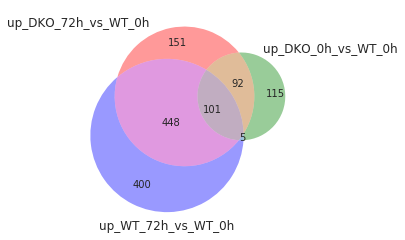

In [283]:
fig,ax = plt.subplots(nrows=1,ncols=1, figsize(8,8))

v=venn3(subsets = (A_solo, B_solo, AB, C_solo, AC, BC,ABC), \
set_labels = (ConA, ConB, ConC))

In [24]:
df_ALL_DEGs 
df_ALL_DEGs = df_ALL_DEGs[[]]

,WT_0h_0_x,WT_0h_1_x,WT_0h_2_x,DKO_0h_1_x,DKO_0h_0_x,DKO_0h_2_x,WT_0h_1_y,WT_0h_0_y,WT_0h_2_y,DKO_72h_0_x,...,WT_72h_2_x,DKO_72h_0,DKO_72h_1,DKO_72h_2,WT_0h_0,WT_0h_1,WT_0h_2,WT_72h_0_y,WT_72h_1_y,WT_72h_2_y
gene_id,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,0.000000,0.112812,0.059732,0.153986,0.000000,0.181385,0.115260,0.000000,0.060973,0.000000,...,0.000000,0.000000,0.000000,0.047922,0.000000,0.113033,0.059866,0.054512,0.000000,0.000000
0610007P14Rik,19.354600,20.269000,17.653900,23.381300,24.753400,22.801300,20.708800,19.758700,18.022200,40.457900,...,38.792200,41.841600,41.184700,33.798800,19.345300,20.308700,17.694500,36.164300,41.028100,37.068200
0610009B22Rik,3.212640,3.855060,3.060170,2.223030,3.925050,3.474840,3.938710,3.279720,3.124020,7.763640,...,9.270530,8.029160,7.832330,5.506040,3.211090,3.862610,3.067200,5.757320,13.047600,8.858510
0610009L18Rik,4.967220,4.741300,3.565590,3.693400,2.973190,4.279740,4.844180,5.070920,3.639970,8.955420,...,6.652170,9.261700,9.312960,8.688730,4.964820,4.750590,3.573780,5.184600,6.004770,6.356520
0610009O20Rik,14.203300,13.722000,14.972000,14.805500,14.605000,14.027300,14.019800,14.499800,15.284300,15.788200,...,17.336600,16.328200,15.974700,16.910200,14.196400,13.748900,15.006300,15.398300,13.379200,16.566000
0610010B08Rik,0.025028,0.047780,0.012643,0.037884,0.022771,0.051215,0.048817,0.025551,0.012906,0.063507,...,0.048988,0.065679,0.072570,0.071009,0.025016,0.047873,0.012672,0.080801,0.065079,0.046811
0610010F05Rik,1.736620,1.894440,1.587370,2.934650,2.056520,2.340890,1.935550,1.772880,1.620480,2.611280,...,3.226460,2.700590,2.968710,3.340560,1.735780,1.898150,1.591010,2.822310,3.309070,3.083060
0610010K14Rik,72.964100,68.471600,70.500800,62.578200,62.546300,63.140100,69.956700,74.487400,71.971300,75.160600,...,82.101600,77.730700,74.976000,57.659200,72.928800,68.605200,70.662500,56.677900,78.081900,78.452600
0610011F06Rik,31.279600,26.188800,28.260200,25.161500,18.213600,20.116600,26.757100,31.932700,28.849800,38.702100,...,44.361200,40.025700,35.464100,30.933900,31.264500,26.240100,28.325100,33.798300,44.075400,42.389600


# heatmap

(5623, 29)

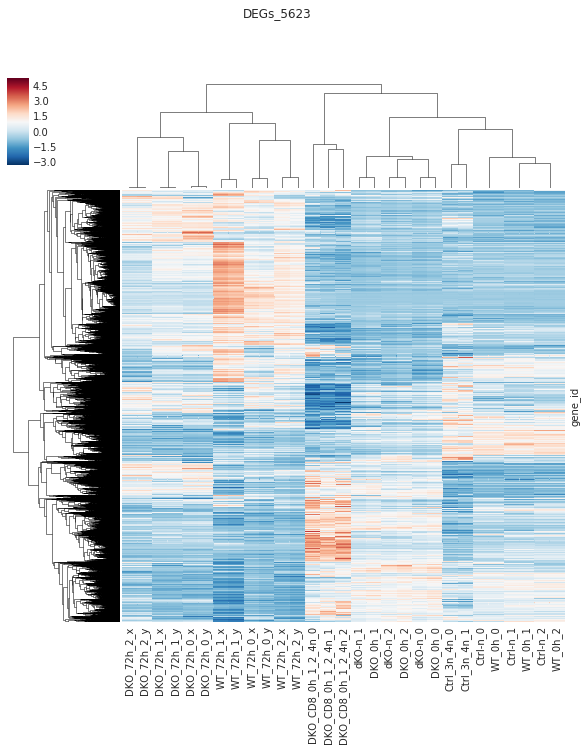

In [15]:
### Drop all zeros rows for plot
Heatmap_Df = df_ALL_DEGs.loc[(df_ALL_DEGs!=0).any(axis=1)]

Heatmap_Name='DEGs_'+str(len(Heatmap_Df.index))
#### Very Important

#Heatmap_Df=FPKM_df.fillna(0)

fig_1 = sns.clustermap(Heatmap_Df,  yticklabels=False, z_score=0, col_cluster=True, cmap='RdBu_r' )
fig_1.savefig(Heatmap_Name+'.png')
fig_1.fig.suptitle(Heatmap_Name)
Heatmap_Df.shape

In [16]:
df_ALL_DEGs = df_ALL_DEGs.rename(columns={'WT_0h_0':'Ctrl-5n','WT_0h_1':'Ctrl-6n','WT_0h_2':'Ctrl-7n',
                           'DKO_0h_0':'dko-5n','DKO_0h_1':'dko-6n','DKO_0h_2':'dko-7n',
                           'WT_72h_0':'WT1_CD8_72h','WT_72h_1':'WT2_CD8_72h', 'WT_72h_2':'Ctrl-3s',
                           'DKO_72h_0':'DKO1_CD8_72h','DKO_72h_1':'DKO2_CD8_72h','DKO_72h_2':'dKO_3s'})

# PCA



## Input a DataFrame then plot.

In [17]:
# PCA
df_2 = df_ALL_DEGs #.reset_index()

#### Remove unicode of list in python 
df2_gene_id = [x.encode('ascii', 'ignore') for x in df_2.index]


from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

#### In here we set targets as the name of columns, which means our purpose is to compare \
#### the relationship between different columns.
targets= [x.encode('ascii', 'ignore') for x in df_2.columns]

colors=[]
for i in range(len(targets)):
    colors.append( "C"+ str(i))
    #print(colors[i])

################################################################################

df_2_T = df_2.transpose()

# Separating out the features
x = df_2_T.loc[ :, df2_gene_id ].values


# Separating out the target
y = df_2_T.loc[targets,:].values


# Standardizing the featuresbio
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


########### THIS is fucking killing me. reindex df with df2, just using following command.
principalDf.index = df_2_T.index

#finalDf = pd.concat( [principalDf, df_2_T.loc['target']], axis = 1)
principalDf

,principal component 1,principal component 2
Ctrl-5n,-58.618141,-62.128835
Ctrl-6n,-63.195967,-70.340065
Ctrl-7n,-65.400853,-67.656714
dko-6n,-84.743849,42.827001
dko-5n,-88.062970,36.670689
dko-7n,-86.314462,28.348753
WT1_CD8_72h,55.708760,-17.724556
WT2_CD8_72h,149.666210,-59.610266
Ctrl-3s,99.482346,-23.671447
DKO1_CD8_72h,68.022081,70.848321


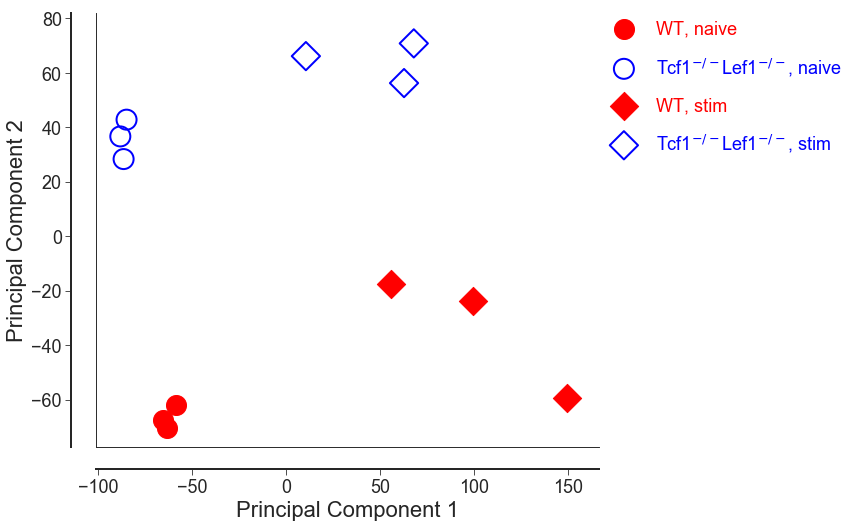

In [285]:
### PLOT
matplotlib.rcParams['font.sans-serif'] = ['Arial'] #, 'sans-serif']

fig = plt.figure(figsize = (9,8))
ax = fig.add_subplot(1,1,1) 

#ax.set_title('Two components PCA', fontsize = 20)

colors = ['red','red','red',
          'blue','blue','blue',
          'red','red','red',
          'blue','blue','blue']
i=0
s_size=400
alpha_value=1
label_set = ['WT, stim', 'Tcf1$^{-/-}$Lef1$^{-/-}$, naive', 'Tcf1$^{-/-}$Lef1$^{-/-}$, stim', 'WT, naive']
for target, color in zip( targets,colors):
    i+=1
    indicesToKeep = principalDf.index == target
    if (i in {7,8,9}):
        ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , s = s_size, c=color, alpha=alpha_value, marker="D", label=label_set[0] if i%3 == 0 else '')
    elif(i in {4,5,6}):
         ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , s = s_size, alpha=alpha_value, facecolors='none', 
                    edgecolors=color, linewidths=2, label=label_set[1] if i%3 == 0 else '')
    elif (i in {10,11,12}):
        ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , s = s_size, alpha=alpha_value, marker="D", facecolors='none', 
                   edgecolors=color, linewidths=2, label=label_set[2] if i%3 == 0 else '')
    else:
        ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , s = s_size, c=color, alpha=alpha_value, label=label_set[3] if i%3 == 0 else '')

    

legend_object = ax.legend(loc="upper right", bbox_to_anchor=(0.50,1, 1,0),edgecolor='w',
          borderaxespad=0,fancybox=True, shadow=False,  fontsize=18, labelspacing=1.0)

# change the font colors to match the line colors:
i=0
for text in legend_object.get_texts():
    text.set_color(colors[i*3])
    i+=1
#ax.set_xlim(-2,8)
#ax.grid(off)






ax2 = ax.twiny()
ax3 = ax.twinx()
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax3.yaxis.set_ticks_position("left")
ax3.yaxis.set_label_position("left")

# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.05))
ax2.spines["bottom"].set_linewidth(2)
ax3.spines["left"].set_position(("axes", -0.05))
ax3.spines["left"].set_linewidth(2)


#ax2.set_frame_on(True)
#ax3.set_frame_on(True)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])

ax2.set_xlim(ax.get_xlim())
ax3.set_ylim(ax.get_ylim())
ax2.tick_params(axis='x',which='major', direction='out', length=6, labelsize=18)
ax2.tick_params(axis='x',which='minor', direction='out', length=6, labelsize=18)
ax3.tick_params(axis='y',which='major', direction='out', length=6, labelsize=18)
ax3.tick_params(axis='y',which='minor', direction='out', length=6, labelsize=18)

ax2.set_xlabel('Principal Component 1', fontsize = 22, fontname='Arial')
ax3.set_ylabel('Principal Component 2', fontsize = 22, fontname="Arial")


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)


Parameters_Detail='CD8_HP'
fig.savefig('PCA'+Parameters_Detail+'.png')

<bound method AxesSubplot.text of <matplotlib.axes._subplots.AxesSubplot object at 0x7f6224487e90>>